In [1]:
#import shapely
#import fiona

In [1]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
## for plotting a polygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd

In [2]:
import shapefile as shp
import regionmask
from descartes import PolygonPatch
import matplotlib.path as mplPath

In [3]:
#uploaded.keys()
in_file = "D:\\Personal_Work\\Ekwacu\\cru_ts3.22.1961-2013.tmn.dat.nc"                      ## Input file
Data = xr.open_dataset(in_file)                            ## read in the data
Data=Data['tmn'].groupby('time.year').mean('time')         ## Group data into yearly means
#Data

In [4]:
dat_samp = Data.sel(lon=slice(27.5, 42.5), lat=slice(-12, 5))
slope_val = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
p_value = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
#output = []
for i in np.arange(len(dat_samp.lat.values)):
    for j in np.arange(len(dat_samp.lon.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [5]:
## Define data as Xarray dataset and save as netcdf

output1=xr.DataArray(slope_val, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="slope.", units="degC year-1"),)
data1 = output1.rename("trend")
#sig_reg = np.ma.array(pval, mask=cond)
output2=xr.DataArray(p_value, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
#output2=xr.DataArray(sig_reg, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")

## Save Data as netcdf

#data.to_netcdf('tas_CanESM5_historical_trend.nc', mode='w')
#data.to_netcdf('tas_CanESM5_historical_pval.nc', mode='w')

In [16]:
## read the Shapeifle of the Area of interest for use in masking over the required region

sf = gpd.read_file('./EA_Shp/East_Africa-Disolved.shp')     ## Used in Masking
sf2 = shp.Reader('./EA_Shp/East_Africa-Disolved.shp')       ## Used in plotting

## Mask the trends and p_values

trend_mask = regionmask.mask_3D_geopandas(sf, data1.lon, data1.lat, lon_name='lon', lat_name='lat')
pval_mask = regionmask.mask_3D_geopandas(sf, data2.lon, data2.lat, lon_name='lon', lat_name='lat')

trnd = data1.where(trend_mask)         ## clip the data with the mask
pval = data2.where(pval_mask)

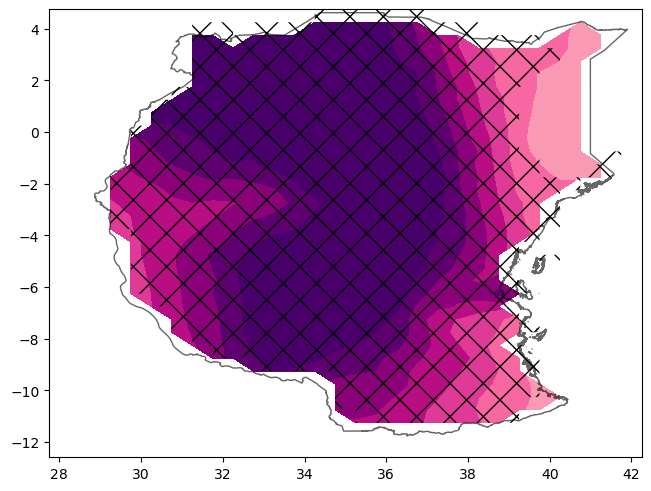

In [33]:
from matplotlib.colors import ListedColormap

none_map = ListedColormap(['none'])
fig, ax = plt.subplots(constrained_layout=True)
#cond = (p_value >= -0.005) | (p_value <= 0.005)

## Change this to the threshold you need.
cond = (pval >= -0.0005) & (pval <= 0.0005)

## Mask out the areas that do not satisfy the conditions
#sig_reg = np.ma.array(pval, mask=cond)
sig_reg = pval.where(cond)

## Plotting the figure

for poly in sf2.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=0.6, fill='False', zorder=2 ))

cs = plt.contourf(dat_samp.lon, dat_samp.lat, trnd.values[:,:,0], 
                  levels=np.arange(0, 0.03, 0.003), cmap=plt.cm.RdPu, extend='both')
hatch = ax.pcolor(dat_samp.lon, dat_samp.lat, sig_reg.data[:,:,0], cmap=none_map, 
                  hatch='x', edgecolor='black', lw=0, zorder=2)

plt.show()

In [ ]:
## Plotting figures with hatches

fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(6.4, 3.2))

hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']


def hatches_plot(ax, h):
    ax.add_patch(Rectangle((0, 0), 2, 2, fill=False, hatch=h))
    ax.text(1, -0.5, f"' {h} '", size=15, ha="center")
    ax.axis('equal')
    ax.axis('off')

for ax, h in zip(axs.flat, hatches):
    hatches_plot(ax, h)

In [ ]:
fig = plt.figure(figsize=(10, 7))
#fig, ax = plt.subplots(3, 5, constrained_layout=True)#figsize=(40,40))
#fig.tight_layout()
proj = ccrs.PlateCarree(central_longitude=0)
#plt.rcParams['figure.figsize'] = [4, 4]

ax = plt.subplot(3,5,1, projection=proj)
for poly in sf.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=0.6, fill='False', zorder=2 ))

for poly in sf3.shapes():
    poly_geo=poly.__geo_interface__
    ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=0.6, fill='False', zorder=2 ))

for poly3 in eac.shapes():
    poly3_geo=poly3.__geo_interface__
    ax.add_patch(PolygonPatch(poly3_geo, fc='None', ec='black', alpha=0.6, fill='False', zorder=2 ))

for pol in sf2.shapes():
    pol_geo=pol.__geo_interface__
    ax.add_patch(PolygonPatch(pol_geo, fc='None', ec='blue', alpha=0.6, fill='False', zorder=2 ))

cs = plt.contourf(rcp26_mam_2080.longitude, rcp26_mam_2080.latitude, rcp26_mam_2080.values[:,:,0], levels=np.arange(-11, 13, 2), cmap=plt.cm.BrBG.reversed(), extend='both')
ax.set_extent([29, 36, -4.2, 1.8])
ax.set_xticks(range(29, 36, 2), crs=ccrs.PlateCarree(central_longitude=0))
ax.set_yticks(range(-3, 1, 1), crs=ccrs.PlateCarree(central_longitude=0))
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
labelsx = ax.get_xticklabels()
labelsy = ax.get_yticklabels()
plt.setp(labelsx, fontsize=10)
plt.setp(labelsy, fontsize=10)
ax.label_outer()
plt.title('MAM', fontsize=15, fontweight="bold")
ax.text(0.1, 0.90, '(a)', fontsize = 12, horizontalalignment='center',
        verticalalignment='center', rotation='horizontal', transform=ax.transAxes)

## Plot 2

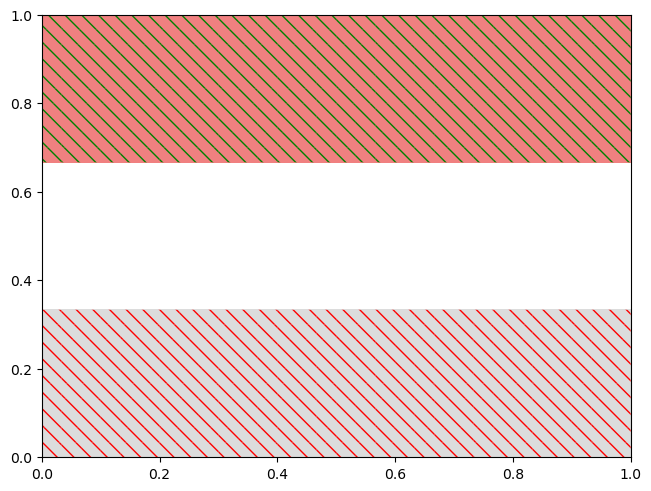

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

x_range = np.linspace(0, 1, 31)
y_range = np.linspace(0, 1, 31)

Z = np.zeros([30, 30])

Z[:10, :] += -1
Z[-10:, :] += 1

fig, ax = plt.subplots(constrained_layout=True)

cond1 = (Z != -1)
mZ1 = np.ma.array(Z, mask=cond1)
gains_map = ListedColormap(['gainsboro'])
none_map = ListedColormap(['none'])
col1 = ax.pcolor(x_range, y_range, mZ1, cmap=gains_map)
hatch1 = ax.pcolor(x_range, y_range, mZ1, cmap=none_map,
                   hatch='\\ \\', edgecolor='red', lw=0, zorder=2)

cond2 = (Z != 1)
mZ2 = np.ma.array(Z, mask=cond2)
coral_map = ListedColormap(['lightcoral'])
col2 = ax.pcolor(x_range, y_range, mZ2, cmap=coral_map)
hatch2 = ax.pcolor(x_range, y_range, mZ2, cmap=none_map,
                   hatch='\\ \\', edgecolor='green', lw=0, zorder=2)
plt.show()

In [186]:
mZ2

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --],
        [--, 